# TODO
1kg restrict based on number of samples
redo with all chromosomes
number of total loci in the table doesn't make sense (want afr~eur, 1000G <=SSC)
clean up plotting (e.g. specify colors, paths, etc. at beginning of file only once)

In [1]:
%pylab inline

# Import our plot library
from vplot import *

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

DATADIR="/storage/s1saini/manuscript_strsnp/fig3/ssc-imputation/"
OUTPATH="pdfs/"
PREFIX="Figure2"

sscloo = pd.read_csv(os.path.join(DATADIR, "loo","l1o.ALL.chr.csv")).drop(['pos'], axis=1).drop_duplicates(subset=['str'])
print(sscloo.shape)
locstats = pd.read_csv(os.path.join(DATADIR, "callstats", "hipstr.ALL.chr.v3.tab"), delim_whitespace=True)
locstats["pos"] = locstats.apply(lambda x: str(x["chrom"])+":"+str(x["start"]), 1)
id_start = pd.read_csv(os.path.join(DATADIR, "loo", "ALL.START_ID.txt"), delim_whitespace=True, names=["str","pos"]).drop_duplicates(subset=['pos'])
locstats = pd.merge(locstats, id_start, on="pos", how="inner")
sscloo = pd.merge(sscloo, locstats, on="str", how="inner")
sscloo = sscloo[sscloo["FILTER"]=="."]
print(sscloo.shape)

Populating the interactive namespace from numpy and matplotlib
(445720, 38)


/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(445725, 50)


In [2]:
sscloo[['loo_concordance']] = sscloo[['loo_concordance']].apply(pd.to_numeric)
sscloo[['loo_r']] = sscloo[['loo_r']].apply(pd.to_numeric)
sscloo[['wgs_eur_r']] = sscloo[['wgs_eur_r']].apply(pd.to_numeric)
sscloo[['wgs_eur_concordance']] = sscloo[['wgs_eur_concordance']].apply(pd.to_numeric)

In [3]:
sscloo.head()

,str,loo_r,loo_pVal,loo_concordance,loo_numSamples,wgs_eur_pVal,wgs_eur_r,wgs_eur_concordance,wgs_eur_numSamples,wgs_afr_pVal,...,end,period,hrun,segdup,hwe.p,numcalls,het,mean_allele,FILTER,pos
0,AAC1C02,0.920650,0.000000e+00,0.930063,955,2.299935e-34,0.984862,0.948980,45.0,1.066675e-08,...,126159262,3.0,2.0,0.0,0.495930,1905.0,0.758215,5.330357,.,10:126159218
1,AFM063xf4,0.955253,0.000000e+00,0.972860,958,1.542805e-21,0.932576,0.959184,47.0,2.762768e-16,...,6721972,2.0,2.0,0.0,0.306553,1912.0,0.699714,1.235110,.,10:6721938
2,ATA20B07,0.963664,0.000000e+00,0.953027,956,1.033870e-31,0.978284,0.979592,46.0,1.660943e-12,...,52678758,3.0,2.0,0.0,0.689554,1877.0,0.600825,-3.757979,.,10:52678723
3,ATA22D02,0.932743,0.000000e+00,0.877871,956,7.819107e-32,0.987082,0.826531,40.0,4.230730e-12,...,129260947,3.0,2.0,0.0,0.618713,1911.0,0.708010,1.545502,.,10:129260918
4,ATA24F10,0.847434,1.400118e-264,0.777662,956,3.147209e-20,0.919094,0.785714,48.0,8.665830e-13,...,64755175,3.0,2.0,0.0,1.000000,1910.0,0.760266,5.348168,.,10:64755137


In [4]:
def gen_boxplot(data, xlabel = "X-Label", ylabel="Y-Label", outputFileName=None,
                xlim=None, ylim=None, outliers=True, xtickLabels=None, ytickLabels=None, 
                xticksFormat=None, yticksFormat=None):
    fig = plt.figure()

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    if outliers is False:
        bp = ax.boxplot(data, patch_artist=True, sym="")
    else:
        bp = ax.boxplot(data, patch_artist=True)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
        box.set( facecolor = '#1b9e77' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

    ## Set X-axis labels
    #ax.set_xticklabels(np.unique(sscloo['numAllele'].values))

    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    # Set axis tite
    ax.set_xlabel(xlabel, size=15);
    ax.set_ylabel(ylabel, size=15);
    
    if xlim is not None:
        ax.set_xlim(xlim)
        
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if xtickLabels is not None:
        ax.set_xticklabels(xtickLabels, size=10)
    if ytickLabels is not None:
        ax.set_yticklabels(ytickLabels, size=12)
    if xticksFormat is not None:
        ax.set_xticklabels([xticksFormat%(x) for x in ax.get_xticks()], size=10);
    if yticksFormat is not None:
        ax.set_yticklabels([yticksFormat%(x) for x in ax.get_yticks()], size=12);
    

    if outputFileName is None:
        outputFileName = "fig" + str(int(np.random.rand()*10**6)) + ".pdf"
    
    fig.savefig(os.path.join(OUTPATH, outputFileName))

In [5]:
def gen_scatter(X, Y, outputFileName=None, marker='.', color='gray', label='_nolegend_', xlabel="X-Label", ylabel="Y-Label", xlim=None, ylim=None, xticksFormat=None, yticksFormat=None, diagonal=False, lr=False, legend=False, alpha=None, empty=False):
    fig = plt.figure()
    ax=fig.add_subplot(111)
    
    if empty is True:
        X = [np.min(X), np.max(X)]
        Y = [np.min(Y), np.max(Y)]
    
    ax.scatter(X, Y, marker=marker, color=color, label=label, alpha=alpha)
    ax.set_xlabel(xlabel, size=15)
    ax.set_ylabel(ylabel, size=15)

    if diagonal is True:
        ax.plot(ax.get_xlim(), ax.get_ylim(), linestyle="dashed", color="black", label="Diagonal")
    
    if xlim is not None:
        ax.set_xlim(xlim)
        
    if ylim is not None:
        ax.set_ylim(ylim)
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    if lr is True:
        m,b=np.polyfit(X, Y, 1)
        X_plot=np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
        ax.plot(X_plot, m*X_plot+b, linestyle="dashed", color="blue", label="Best fit")

    ax.set_xticklabels(ax.get_xticks(), size=12);
    ax.set_yticklabels(ax.get_yticks(), size=12);
    
    if xticksFormat is not None:
        ax.set_xticklabels([xticksFormat%(x) for x in ax.get_xticks()], size=10);
    if yticksFormat is not None:
        ax.set_yticklabels([yticksFormat%(x) for x in ax.get_yticks()], size=12);
    
    if legend is True:
        legend = ax.legend(loc="upper center")
        
    if outputFileName is None:
        outputFileName = "fig" + str(int(np.random.rand()*10**6)) + ".pdf"
    fig.savefig(os.path.join(OUTPATH, outputFileName))
    print(scipy.stats.pearsonr(X,Y))

# Figure 2B: LOO Concordance vs. Heterozygosity

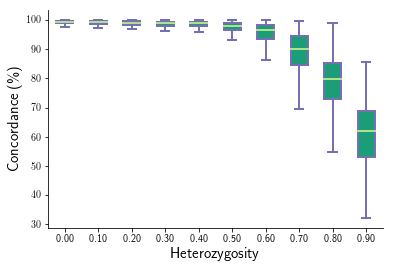

In [12]:
HETBIN=0.1
sscloo["hetbin"] = sscloo["het"].apply(lambda x: int(x/HETBIN)*HETBIN)
hetbins = np.unique(sscloo['hetbin'].values)
fullList = list()
for i in hetbins:
    fullList.append((sscloo[sscloo.hetbin==i]['loo_concordance'].values*100))

def GetLabel(x):
    if int(x*100)%10 == 0: return "%.2f"%x
    else: return ""
xticklabels = [GetLabel(x) for x in hetbins]

gen_boxplot(fullList, xlabel="Heterozygosity", ylabel="Concordance (\%)",
            outliers=False,
            outputFileName="%s_SSCConcVsHet.pdf"%PREFIX, xtickLabels=xticklabels)

# Supplementary: SSC LOO r2 vs. num alleles

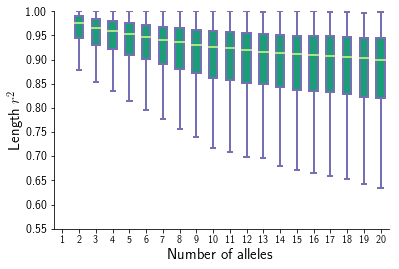

In [13]:
fullList = list()
numAlleles =  np.arange(1, 21)
for i in numAlleles:
    fullList.append((sscloo[sscloo.numAllele==i]['loo_r'].apply(lambda x: x**2).values))
    
xticklabels = ([int(x) for x in numAlleles])

gen_boxplot(fullList, xlabel = "Number of alleles", ylabel=r"Length $r^2$", 
            outputFileName="SuppFig_SSCR2VsNumAlleles.pdf", ylim=[0.55,1], outliers=False, 
            xtickLabels=xticklabels, yticksFormat="%.2f")

# Figure 2C Allele-r2 vs. frequency

In [6]:
ar2 = pd.read_csv(os.path.join(DATADIR, "loo","l1o.allelic.v3.tab"), delim_whitespace=True)
FREQBIN=0.05
ar2["freqbin"] = ar2["freq_het"].apply(lambda x: int(min([x,1-x])/FREQBIN)*FREQBIN)
fbins = np.unique(ar2['freqbin'].values)

/usr/lib64/python3.4/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:2058: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:2065: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:2073: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:2074: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


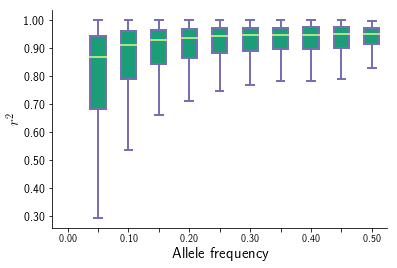

In [22]:
fullList = list()
for i in fbins:
    fullList.append((ar2[(ar2.freqbin==i)]['r2'].values))
    
def GetLabel(x):
    if int(x*100)%10 == 0: return "%.2f"%x
    else: return ""
xticklabels = ([GetLabel(x) for x in fbins])
    
gen_boxplot(fullList, xlabel = "Allele frequency", ylabel=r"$r^2$", outputFileName="%s_SSCAfreq_vs_R2.pdf"%PREFIX,
            outliers=False, xtickLabels=xticklabels, yticksFormat="%.2f")


# Figure 2D 1KG vs. SSC concordance

(0.9406240172244381, 0.0)


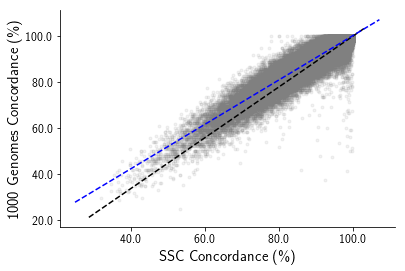

In [8]:
gen_scatter(sscloo[['loo_concordance', 'wgs_eur_concordance']].dropna().loo_concordance*100, sscloo[['loo_concordance', 'wgs_eur_concordance']].dropna().wgs_eur_concordance*100, outputFileName="%s_SSCVs1kgConc.pdf"%PREFIX, xlabel="SSC Concordance (\%)", ylabel="1000 Genomes Concordance (\%)", diagonal=True, lr=True, legend=False, alpha=0.1)

(1.0, 0.0)


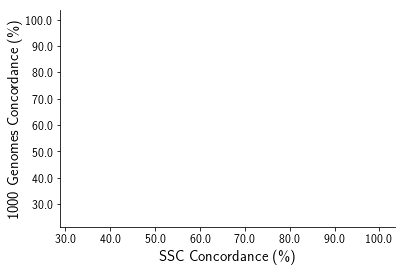

In [57]:
gen_scatter(sscloo.loo_concordance*100, sscloo.wgs_eur_concordance*100, outputFileName="%s_SSCVs1kgConc_empty.pdf"%PREFIX, xlabel="SSC Concordance (\%)", ylabel="1000 Genomes Concordance (\%)", alpha=0, empty=True)

# Figure 2E: 1kg vs. SSC allele-r2

In [7]:
MINFREQ=0.05
onekg_r2 = pd.read_csv(os.path.join(DATADIR, "onekg", "ALL.eur.allelic.v3.tab"), delim_whitespace=True)
onekg_r2["kgr2"] = onekg_r2["r2"]
onekg_r2 = onekg_r2[onekg_r2["freq_het"]>=MINFREQ]
onekg_r2 = pd.merge(onekg_r2[["locus1","allele","kgr2"]], ar2[["locus1","allele","r2","freq_het"]], on=["locus1","allele"])
onekg_r2 = onekg_r2[~np.isnan(onekg_r2.kgr2) & ~np.isnan(onekg_r2.r2) & (onekg_r2["freq_het"]>=MINFREQ)]

(0.8457580527128024, 0.0)


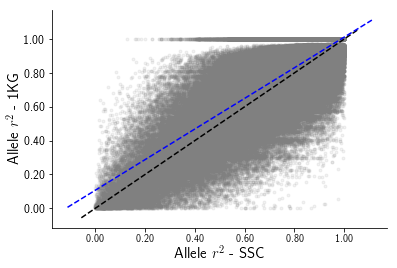

In [9]:
gen_scatter(onekg_r2.r2, onekg_r2.kgr2, outputFileName="%s_SSCVs1kgAlleler2.pdf"%PREFIX, xlabel=r'Allele $r^2$ - SSC', ylabel=r'Allele $r^2$ - 1KG', xticksFormat="%.2f", yticksFormat="%.2f", diagonal = True, lr=True, legend=False, alpha=0.1)

(1.0, 0.0)


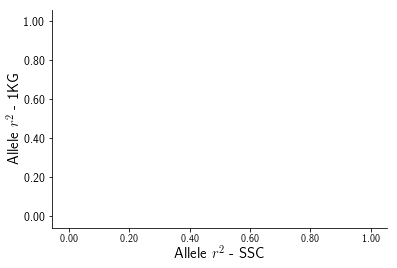

In [58]:
gen_scatter(onekg_r2.r2, onekg_r2.kgr2, outputFileName="%s_SSCVs1kgAlleler2_empty.pdf"%PREFIX, xlabel=r'Allele $r^2$ - SSC', ylabel=r'Allele $r^2$ - 1KG', xticksFormat="%.2f", yticksFormat="%.2f", alpha=0, empty=True)

# Supplemental: 1kg vs. SSC r2

(0.6371847136066084, 0.0)


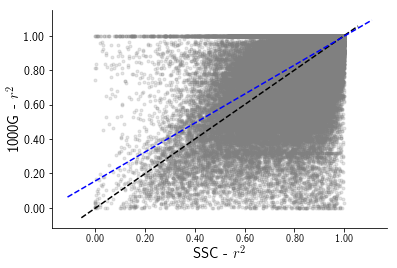

In [10]:
gen_scatter(sscloo[['loo_r', 'wgs_eur_r']].dropna().loo_r**2, sscloo[['loo_r', 'wgs_eur_r']].dropna().wgs_eur_r**2, outputFileName="SuppFig_1KGvsSSCr.pdf", xlabel=r"SSC - $r^2$", ylabel=r"1000G - $r^2$", xticksFormat="%.2f", yticksFormat="%.2f", diagonal=True, lr=True, legend=False, alpha=0.2)

(1.0, 0.0)


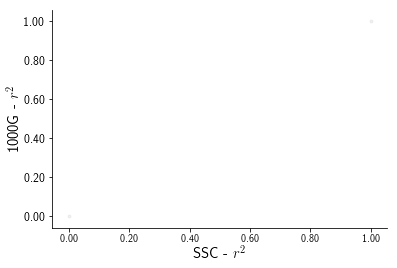

In [60]:
gen_scatter(sscloo["loo_r"]**2, sscloo["wgs_eur_r"]**2, outputFileName="SuppFig_1KGvsSSCr_empty.pdf", xlabel=r"SSC - $r^2$", ylabel=r"1000G - $r^2$", xticksFormat="%.2f", yticksFormat="%.2f", alpha=0.1, empty=True)

# Supplementary: R2 vs. mutation rate

In [18]:
mutrate = pd.read_csv("/storage/mgymrek/ssc-denovos/mutea-results/ssc_mutea_auto_scaled.bed.gz", sep="\t",
                     names=["chrom","start","log10mu"], usecols=[0,1,3])
mutrate = pd.merge(mutrate, sscloo, on=["chrom","start"])
mutrate = mutrate[(mutrate["log10mu"]>=-6) & (mutrate["log10mu"]<=-2)]

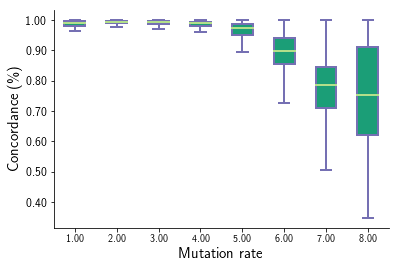

In [19]:
MUTBIN=0.5
mutrate["mutbin"] = mutrate["log10mu"].apply(lambda x: int(x/MUTBIN)*MUTBIN)
mbins = np.unique(mutrate['mutbin'].values)
fullList = list()
for i in mbins:
    fullList.append((mutrate[(mutrate.mutbin==i)]['loo_concordance']))
    

gen_boxplot(fullList, xlabel="Mutation rate", ylabel="Concordance (\%)", outputFileName="SuppFig_SSCConcordVsMutrate.pdf", outliers=False, xticksFormat="%.2f", yticksFormat="%.2f")

# Table 1

In [20]:
# Get r1, concordance
MINFREQ=0.05
ssc = ["SSC - LOO", sscloo.shape[0], np.mean(sscloo["loo_concordance"]), np.mean(sscloo["loo_r"].apply(lambda x: x**2)),
       np.mean(ar2[ar2["freq_het"]>=MINFREQ]["r2"])]


kg_eur = ["1000G-EUR", sscloo.shape[0], np.mean(sscloo["wgs_eur_concordance"]), np.mean(sscloo["wgs_eur_r"].apply(lambda x: x**2)),
         np.mean(onekg_r2[onekg_r2["freq_het"]>=MINFREQ]["r2"])]

    
onekg_r2_afr = pd.read_csv(os.path.join(DATADIR, "onekg", "ALL.afr.allelic.v3.tab"), sep="\t")
kg_afr = ["1000G-AFR", sscloo.shape[0], np.mean(sscloo["wgs_afr_concordance"]), np.mean(sscloo["wgs_afr_r"].apply(lambda x: x**2)),
         np.mean(onekg_r2_afr[onekg_r2_afr["freq_het"]>=MINFREQ]["r2"])]

onekg_r2_eas = pd.read_csv(os.path.join(DATADIR, "onekg", "ALL.eas.allelic.v3.tab"), sep="\t")
kg_eas = ["1000G-EAS", sscloo.shape[0], np.mean(sscloo["wgs_eas_concordance"]), np.mean(sscloo["wgs_eas_r"].apply(lambda x: x**2)),
         np.mean(onekg_r2_eas[onekg_r2_eas["freq_het"]>=MINFREQ]["r2"])]

for data in [ssc, kg_eur, kg_afr, kg_eas]:
    print("\t".join([str(item) for item in data]))

SSC - LOO	445725	0.9672232865554864	0.9062422663464911	0.8618294174534402
1000G-EUR	445725	0.9708624812716761	0.9210844452185193	0.8717825111148827
1000G-AFR	445725	0.9067702485799951	0.7460793405696277	0.700136346279872
1000G-EAS	445725	0.9380023945729106	0.823404382145245	0.7738294451520232


# Supplemental: SNP-SNP vs. SNP-STR LD

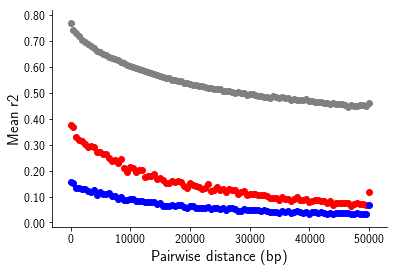

In [7]:
BINSIZE=500
# Load SNPSTR
snpsnp = pd.read_csv(os.path.join("/storage/mgymrek/ssc-imputation/", "snpstr-ld", "snp_pairwise_ld_chr21.tab"), sep="\t",
                    names=["distance","r2"])
snpstr = pd.read_csv(os.path.join("/storage/mgymrek/ssc-imputation/", "snpstr-ld", "snp_str_ld_chr21.tab"), sep="\t",
                      usecols=[0,1,3,6])
snpstr["chrom"] = snpstr["locus1"].apply(lambda x: x.split(":")[0])
snpstr["start"] = snpstr["locus1"].apply(lambda x: int(x.split(":")[1]))
snpstr["distance"] = snpstr.apply(lambda x: abs(int(x["locus1"].split(":")[1])-int(x["locus2"].split(":")[1])), 1)

# Load SNPSTR - allele
snpstr_a = pd.read_csv(os.path.join("/storage/mgymrek/ssc-imputation/", "snpstr-ld", "snp_str_ld_chr21_allele.tab"), sep="\t",
                      usecols=[0,1,2,3,6])
snpstr_a = snpstr_a[~np.isnan(snpstr_a["r2"])]
snpstr_a["chrom"] = snpstr_a["locus1"].apply(lambda x: x.split(":")[0])
snpstr_a["start"] = snpstr_a["locus1"].apply(lambda x: int(x.split(":")[1]))
snpstr_a["distance"] = snpstr_a.apply(lambda x: abs(int(x["locus1"].split(":")[1])-int(x["locus2"].split(":")[1])), 1)

snpstr_best = snpstr.groupby("start", as_index=False).agg({"r2": max, "freq_het": np.mean})
snpstr_best_a = snpstr_a.groupby("start", as_index=False).agg({"r2": max,"freq_het": np.mean})

snpsnp["distbin"] = (snpsnp["distance"]/BINSIZE).apply(int)
snpsnp_bins = snpsnp.groupby("distbin", as_index=False).agg({"r2": np.mean})

snpstr["distbin"] = (snpstr["distance"].apply(abs)/BINSIZE).apply(int)
snpstr_bins = snpstr.groupby("distbin", as_index=False).agg({"r2": np.mean})

snpstr_a["distbin"] = (snpstr_a["distance"].apply(abs)/BINSIZE).apply(int)
snpstr_a_bins = snpstr_a.groupby("distbin", as_index=False).agg({"r2": np.mean})


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(snpsnp_bins["distbin"]*BINSIZE, snpsnp_bins["r2"], color="gray");
ax.scatter(snpstr_bins["distbin"]*BINSIZE, snpstr_bins["r2"], color="red");
ax.scatter(snpstr_a_bins["distbin"]*BINSIZE, snpstr_a_bins["r2"], color="blue");

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Pairwise distance (bp)", size=15)
ax.set_ylabel("Mean r2", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.2f"%(x) for x in ax.get_yticks()], size=12);

fig.savefig(os.path.join(OUTPATH, "SuppFig_SnpStrLD.pdf"))

In [25]:
ssc_vs_onekg = sscloo[['loo_concordance', 'wgs_eur_concordance']].dropna()
print("Concordance ", scipy.stats.pearsonr(ssc_vs_onekg.iloc[:,0], ssc_vs_onekg.iloc[:,1]))
ssc_vs_onekg = sscloo[['loo_r', 'wgs_eur_r']].dropna()
print("r ", scipy.stats.pearsonr(ssc_vs_onekg.iloc[:,0]**2, ssc_vs_onekg.iloc[:,1]**2))


Concordance  (0.9406240172244376, 0.0)
r  (0.6371847136066084, 0.0)
